#### 정규화하지 않는 데이터로 모델링

In [1]:
import pandas as pd
import shap

# 사용할 모델
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from freeman.plt_setting import plt_settings
from freeman.evaluation import regression_evaluation, f_importances, plot_actual_pred
from freeman.aiddd.data_manager import read_data

plt_settings()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# dtype_options = {'pole12_comp_no': str, 'pole12_xy': object}
df_X = read_data('fa-modeling-X-2')
df_y = read_data('fa-modeling-y-2')

In [3]:
training_columns = df_X.columns

In [4]:
X_train, X_test, y_train, y_test = \
    train_test_split(df_X, df_y, test_size=0.1)
    
X_test_copy = X_test.copy()

In [5]:
SEED = 123
ml_models = {
    'LIN': LinearRegression(),
    'LASSO': Lasso(),
    'RIDGE': Ridge(),
    'KNR': KNeighborsRegressor(),
    'DTR': DecisionTreeRegressor(),
    'RFR': RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=SEED),
    'GBR': GradientBoostingRegressor(),
    'EN': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=SEED),
    'XGR': XGBRegressor(eta=0.01, n_estimators=100, n_jobs=-1),
}

In [6]:
def diff_ytest_pred(model_key, test, pred):
    test = test['total_cons_cost'].values.tolist()
    pred = pred.tolist()
    if isinstance(pred[0], list):
        pred = [item for sub in pred for item in sub]
    max_test = max(test)
    loop_size = len(test)
    result_mape = []
    result_max_mape = []
    for idx in range(loop_size):
        new_mape = abs((test[idx] - pred[idx])/test[idx])*100
        new_max_mape = abs((test[idx] - pred[idx])/(test[idx]+max_test))*100
        result_mape.append(new_mape)
        result_max_mape.append(new_max_mape)
    X_test_copy[f'{model_key}_mape'] = result_mape
    X_test_copy[f'{model_key}_max_mape'] = result_max_mape

In [7]:
def model_fit_and_evaluation(model_key, display_start=0, display_size=50):
    model = ml_models[model_key]
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(f'Evaluation: {model_key}')
    evaluation_value = regression_evaluation(y_test, predictions)
    evaluation_values.append(evaluation_value)
    model_names.append(model_key)
    diff_ytest_pred(model_key, y_test, predictions)
    try:
        f_importances(model, training_columns, model_key)
    except AttributeError as e:
        print(f'`{model_key}` object has no attribute `feature_importances_`')
    plot_actual_pred(
        y_test[display_start:display_start+display_size],
        predictions[display_start:display_start+display_size],
        model_key
    )
    return model

Evaluation: LIN
R2_SCORE: 0.609266, MAPE: 15.806904, MSE: 3533587869439.820801, RMSE: 1879783.995421, MAE: 1000463.687351
`LIN` object has no attribute `feature_importances_`


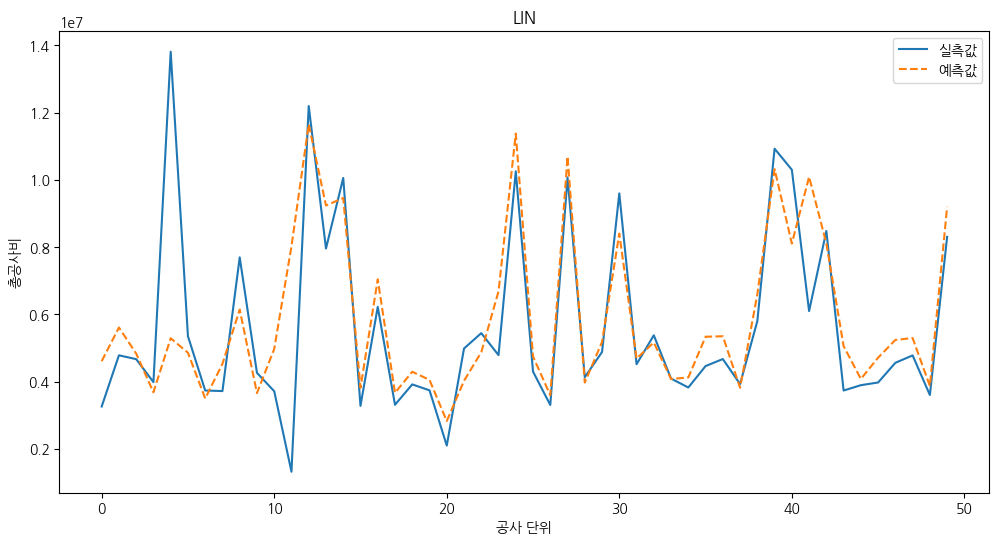

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.403e+15, tolerance: 5.090e+12


Evaluation: LASSO
R2_SCORE: 0.608928, MAPE: 15.797275, MSE: 3536646049220.486328, RMSE: 1880597.258644, MAE: 999499.515762
`LASSO` object has no attribute `feature_importances_`


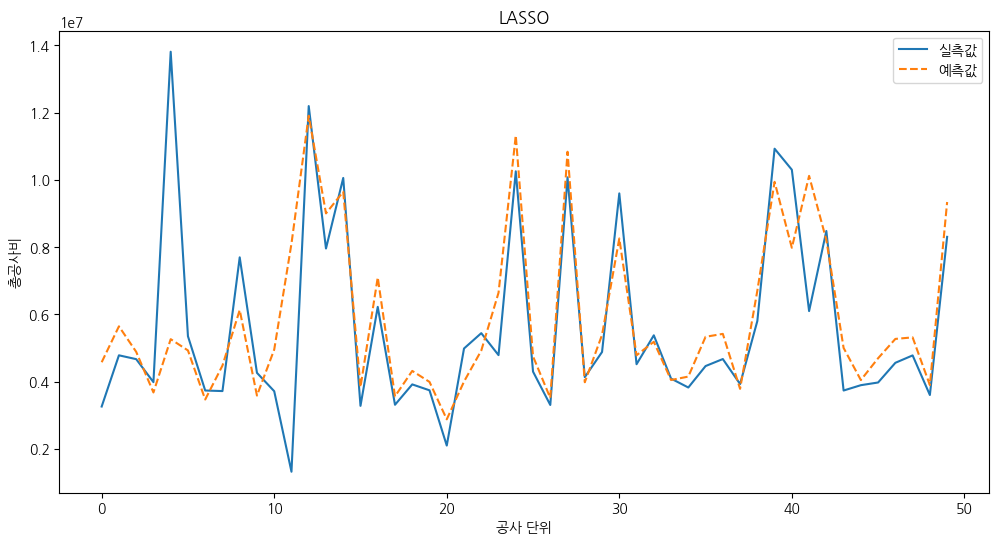

Ill-conditioned matrix (rcond=4.41004e-22): result may not be accurate.


Evaluation: RIDGE
R2_SCORE: 0.607774, MAPE: 15.813635, MSE: 3547083176348.469238, RMSE: 1883370.164452, MAE: 1002190.601750
`RIDGE` object has no attribute `feature_importances_`


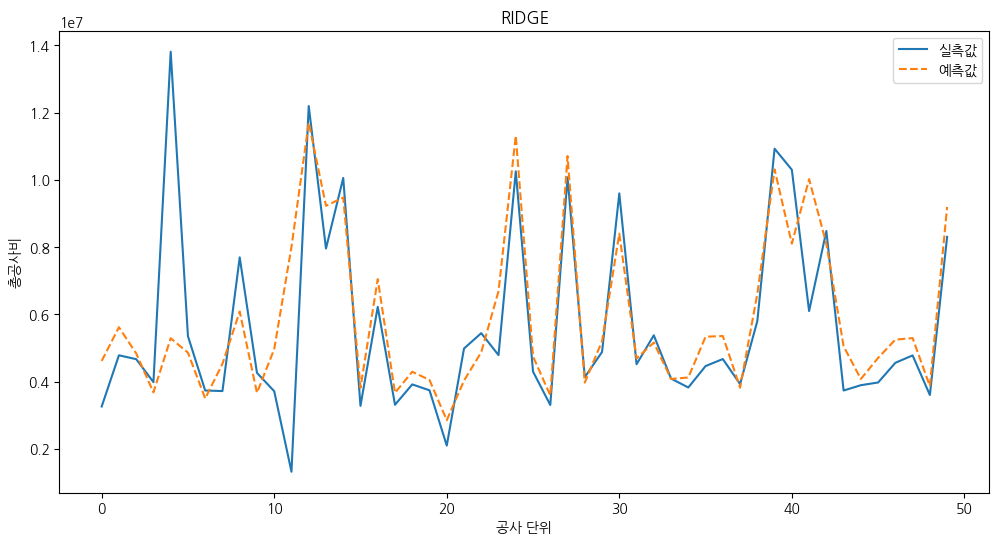

Evaluation: KNR
R2_SCORE: 0.264217, MAPE: 25.763654, MSE: 6654026552262.593750, RMSE: 2579539.988498, MAE: 1566473.286425
`KNR` object has no attribute `feature_importances_`


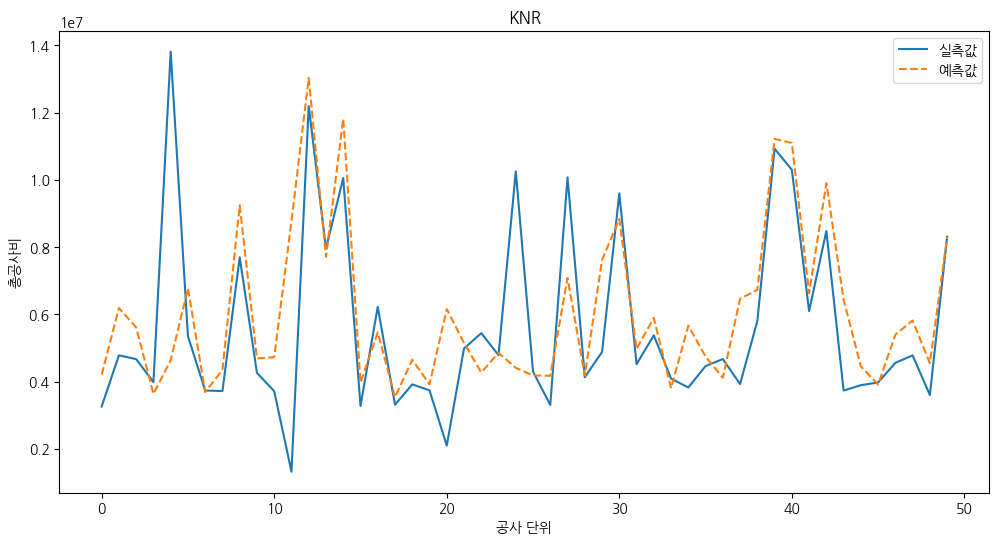

Evaluation: DTR
R2_SCORE: 0.045299, MAPE: 24.368785, MSE: 8633802051235.635742, RMSE: 2938333.209702, MAE: 1517200.205882


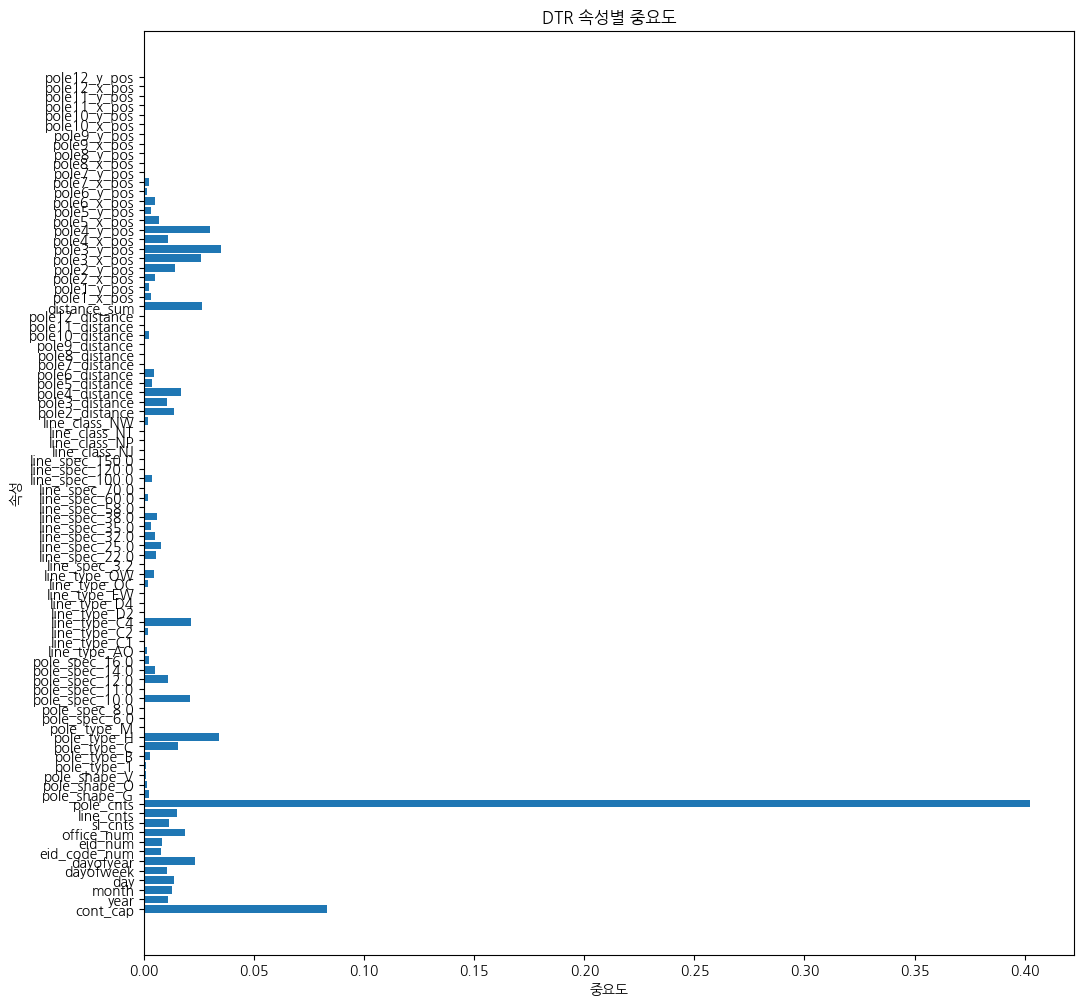

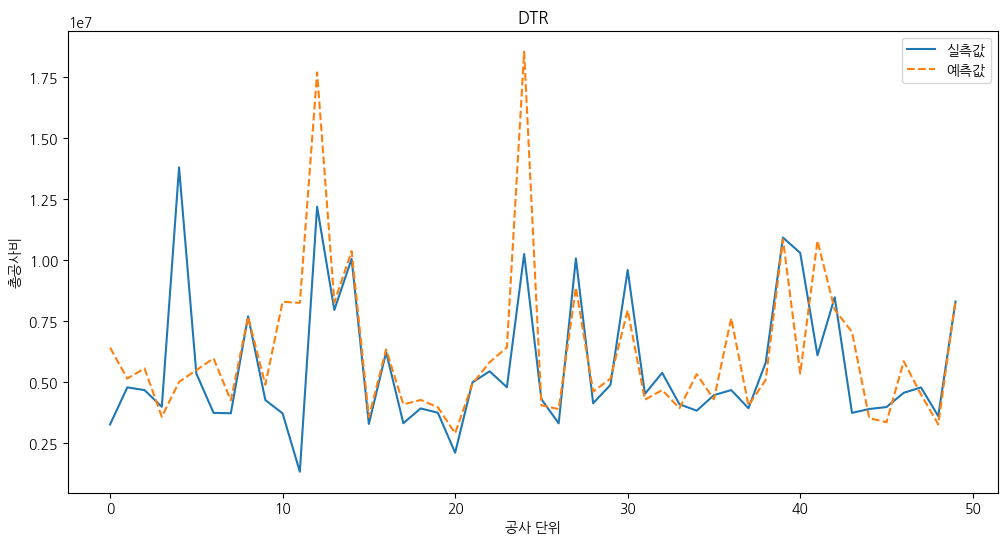

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Evaluation: RFR
R2_SCORE: 0.583741, MAPE: 17.274687, MSE: 3764421716439.913086, RMSE: 1940211.771029, MAE: 1095198.727941


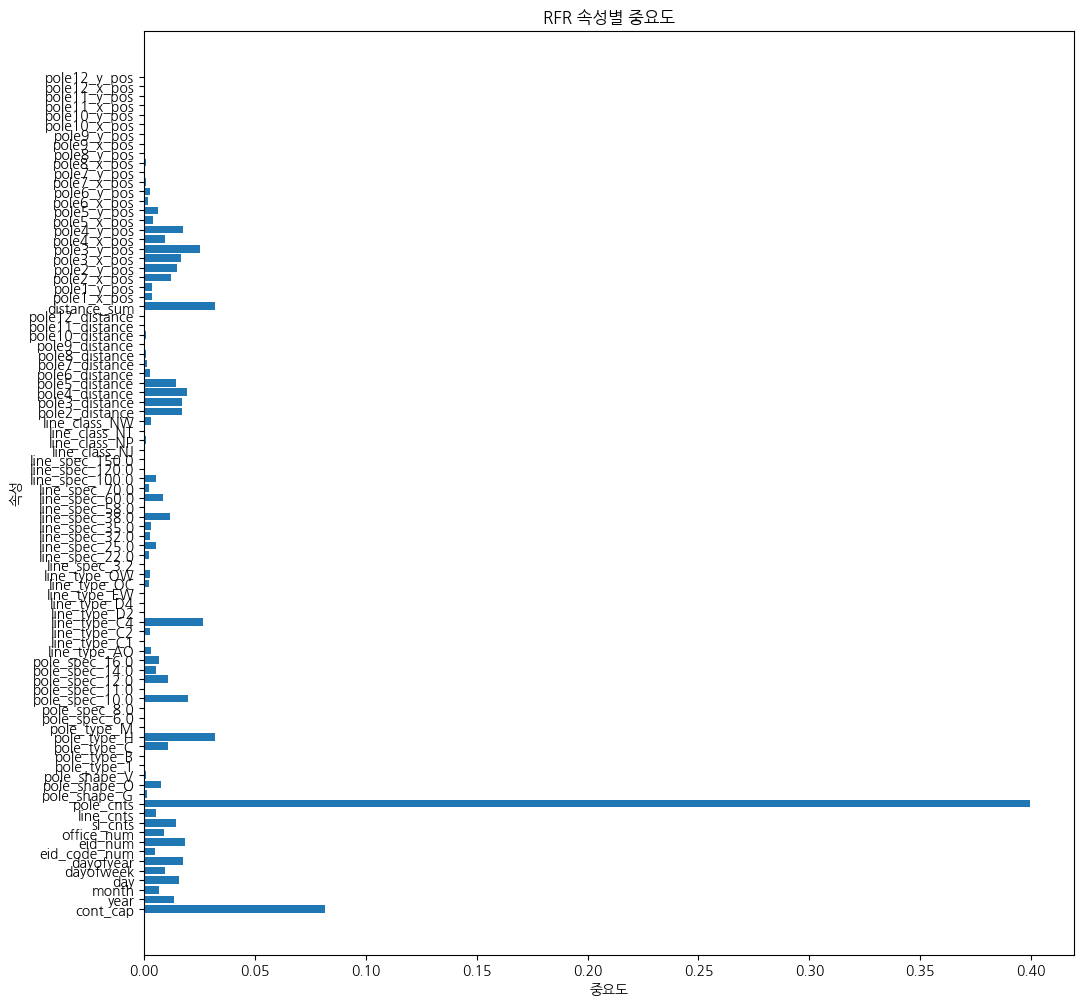

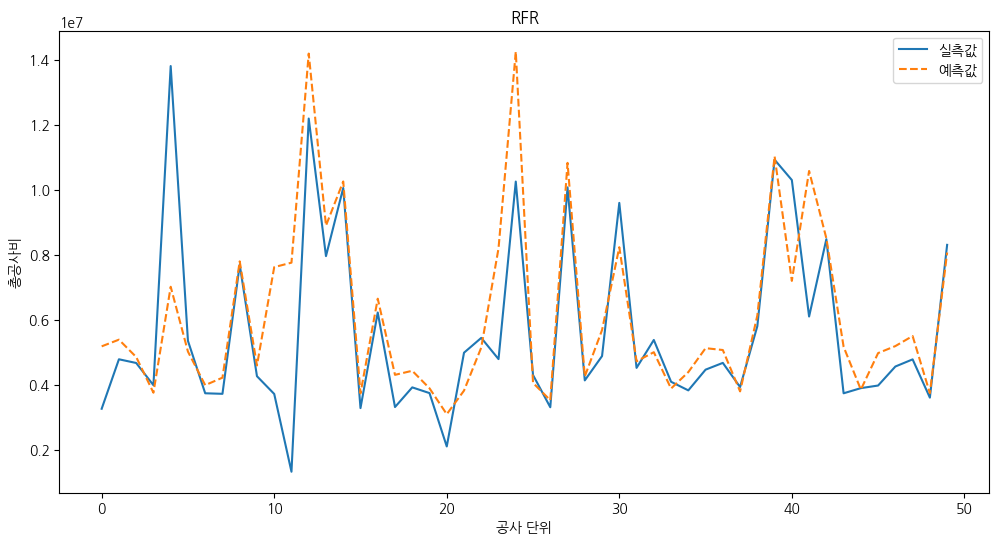

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Evaluation: GBR
R2_SCORE: 0.628419, MAPE: 16.586197, MSE: 3360381594794.366699, RMSE: 1833134.363541, MAE: 1032741.891134


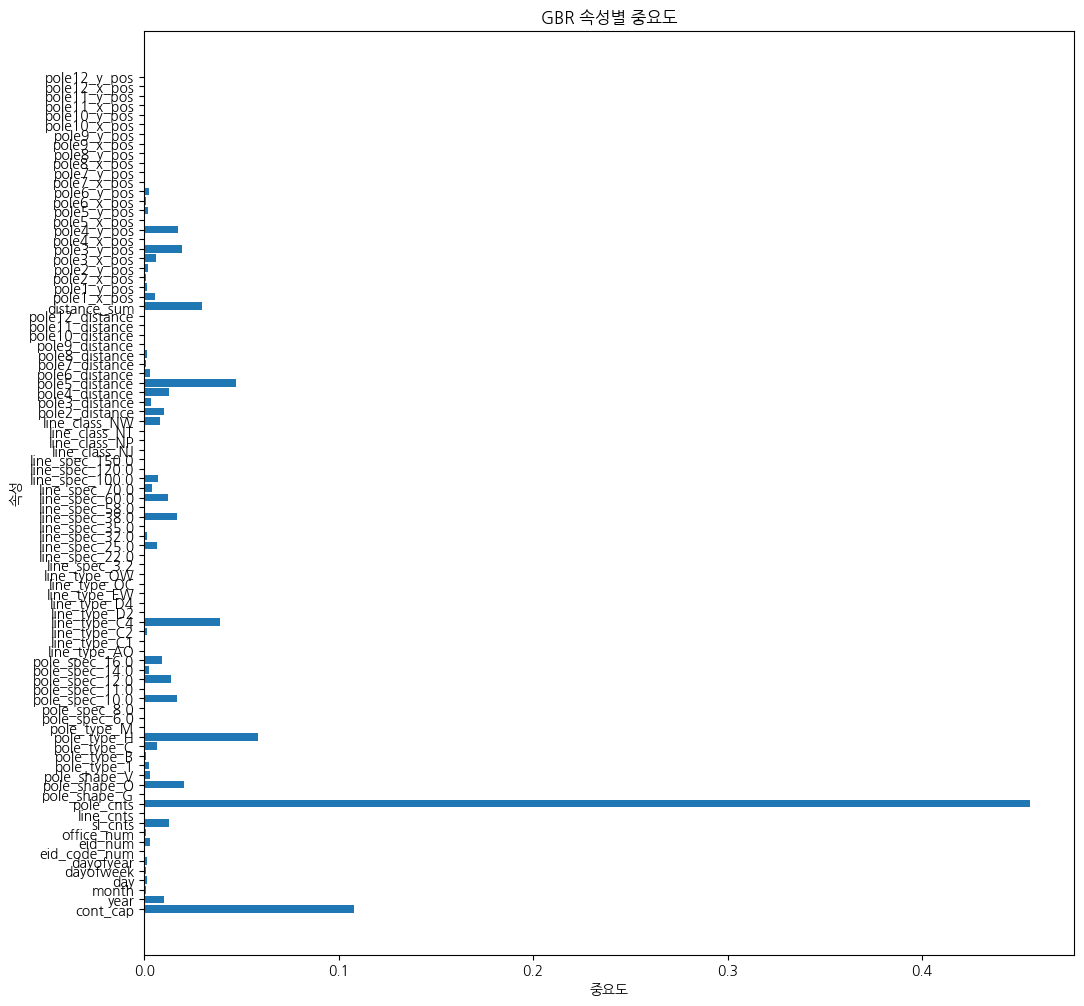

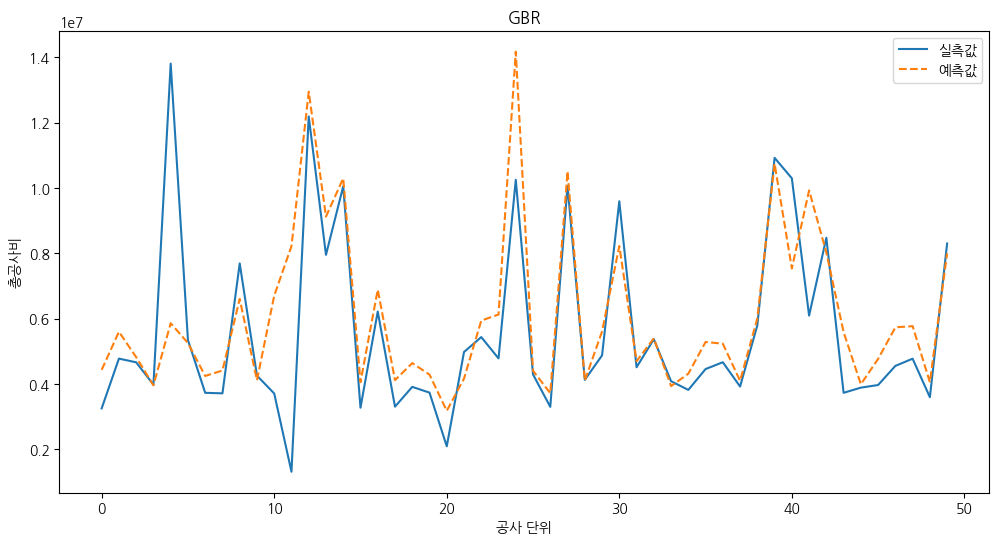

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.269e+15, tolerance: 5.090e+12


Evaluation: EN
R2_SCORE: 0.612717, MAPE: 16.161384, MSE: 3502376060890.251465, RMSE: 1871463.614632, MAE: 1019584.785383
`EN` object has no attribute `feature_importances_`


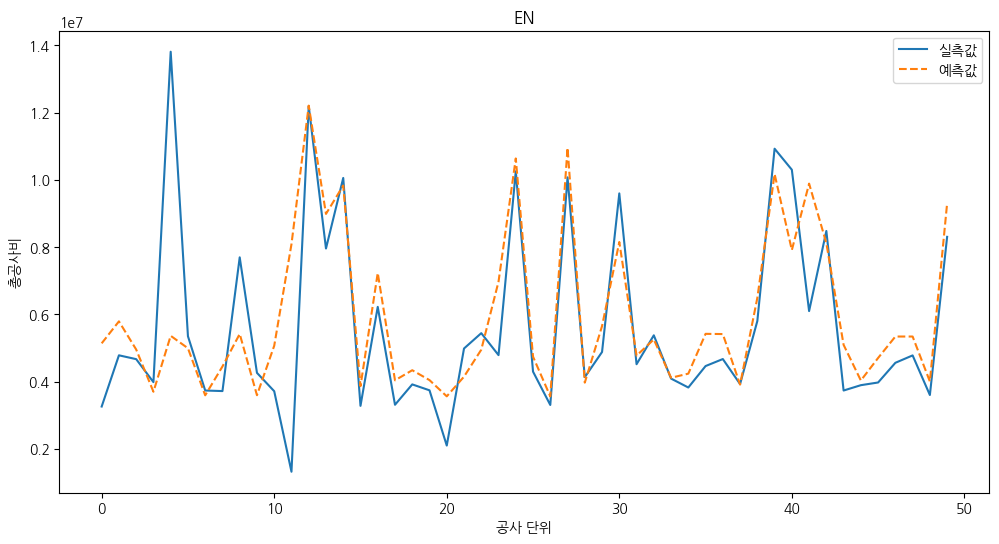

Evaluation: XGR
R2_SCORE: -0.065101, MAPE: 34.078077, MSE: 9632198705881.742188, RMSE: 3103578.371152, MAE: 2286960.401584


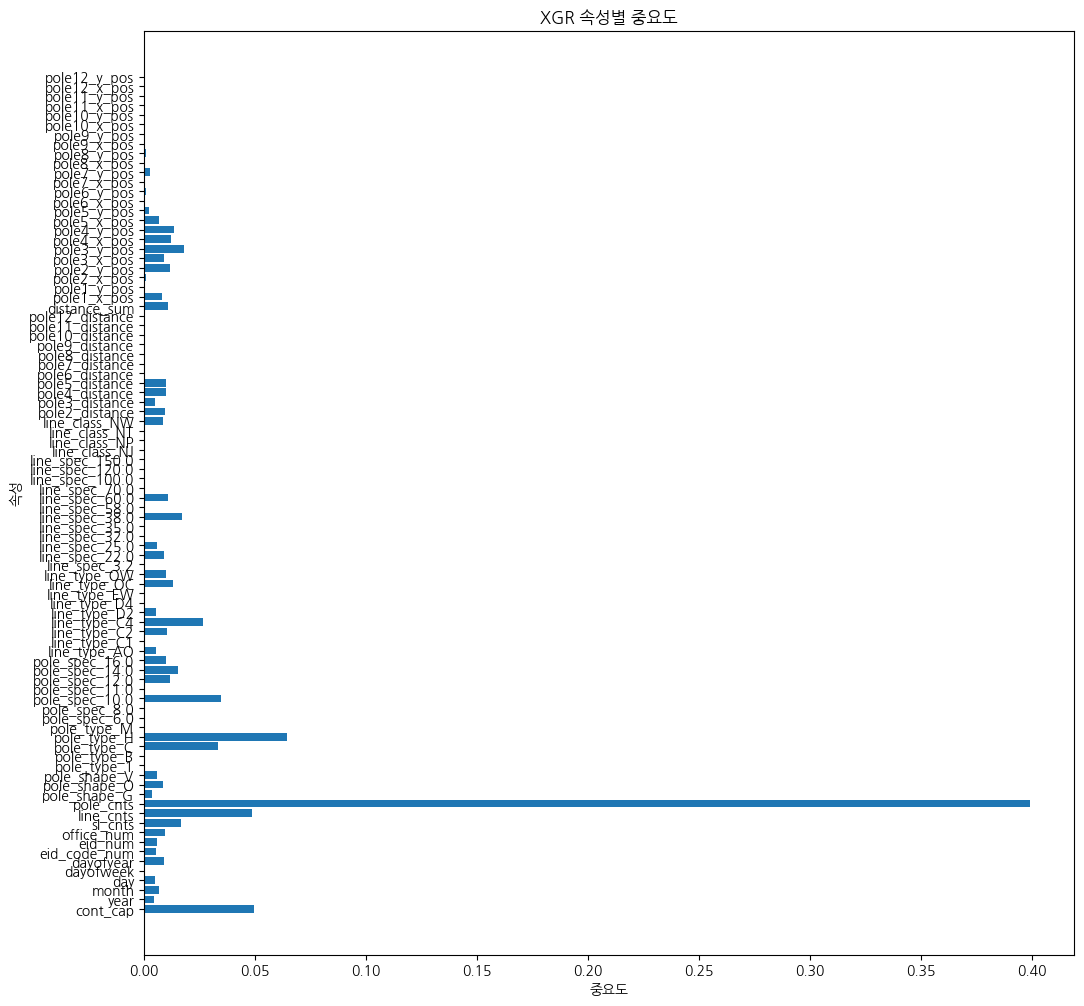

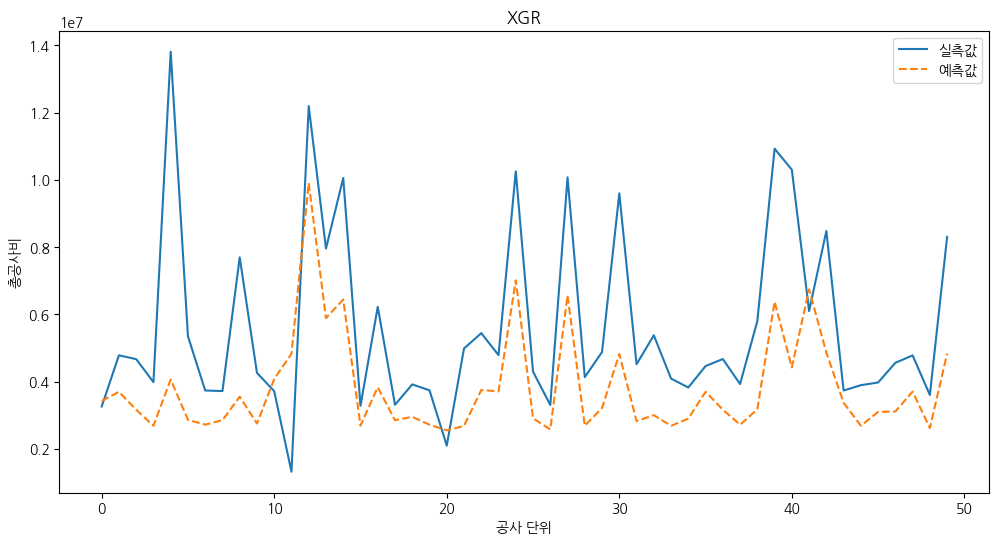

In [8]:
evaluation_values = []
model_names = []
column_names = ['r2score', 'mape', 'mse', 'rmse', 'mae']
models = {}
for _model_key in ml_models.keys():
    model = model_fit_and_evaluation(_model_key, display_start=50, display_size=50)
    models[_model_key] = model
df_evaluation = pd.DataFrame(
    evaluation_values, columns=column_names, index=model_names
)

In [9]:
df_evaluation

,r2score,mape,mse,rmse,mae
LIN,0.609266,0.158069,3.533588e+12,1.879784e+06,1.000464e+06
LASSO,0.608928,0.157973,3.536646e+12,1.880597e+06,9.994995e+05
RIDGE,0.607774,0.158136,3.547083e+12,1.883370e+06,1.002191e+06
KNR,0.264217,0.257637,6.654027e+12,2.579540e+06,1.566473e+06
DTR,0.045299,0.243688,8.633802e+12,2.938333e+06,1.517200e+06
RFR,0.583741,0.172747,3.764422e+12,1.940212e+06,1.095199e+06
GBR,0.628419,0.165862,3.360382e+12,1.833134e+06,1.032742e+06
EN,0.612717,0.161614,3.502376e+12,1.871464e+06,1.019585e+06
XGR,-0.065101,0.340781,9.632199e+12,3.103578e+06,2.286960e+06


In [10]:
X_test_stats = X_test_copy[[
    col for col in X_test_copy.columns if col.endswith('_mape')
]].copy()

In [11]:
X_test_stats.describe().T.style.format('{:.4}')

,count,mean,std,min,25%,50%,75%,max
LIN_mape,442.0,15.81,28.28,0.02574,4.656,10.46,19.3,509.2
LIN_max_mape,442.0,2.876,3.93,0.00531,0.7528,1.781,3.069,36.28
LASSO_mape,442.0,15.8,28.51,0.01801,4.297,10.4,19.28,515.3
LASSO_max_mape,442.0,2.873,3.934,0.002866,0.7223,1.707,3.14,36.29
RIDGE_mape,442.0,15.81,28.21,0.1585,4.679,10.46,19.32,507.8
RIDGE_max_mape,442.0,2.88,3.934,0.0255,0.7528,1.778,3.061,36.26
KNR_mape,442.0,25.76,38.27,0.004327,6.977,17.09,32.08,565.9
KNR_max_mape,442.0,4.55,5.333,0.0006773,1.249,2.818,5.724,34.48
DTR_mape,442.0,24.37,45.12,0.009876,5.816,13.02,25.16,526.1
DTR_max_mape,442.0,4.425,7.15,0.001994,0.9585,2.046,4.875,72.75


In [12]:
df_lin_max_mape = X_test_copy[X_test_copy['LIN_mape']>50].copy()

In [13]:
explainer = shap.Explainer(models['GBR'])

In [14]:
shap_values = explainer(X_train)

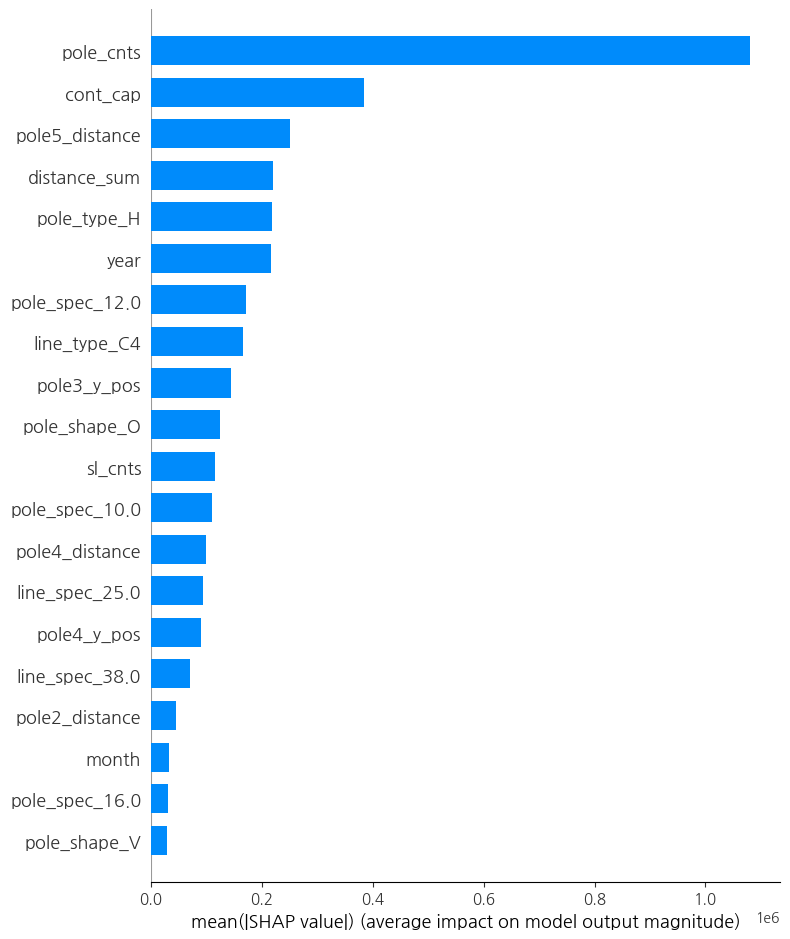

In [15]:
# GBR
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [16]:
sample_idx = 0  # 원하는 샘플의 인덱스
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[sample_idx], X_train.iloc[sample_idx, :])

AssertionError: visualize() can only display Explanation objects (or arrays of them)!